In [1]:
import pandas as pd
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import datetime
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, f1_score

import torch
import torch.nn as nn
import torch.utils.data as data_utils

import utils
import USAD

import numpy as np
pd.set_option('display.width', 1000)
pd.options.display.float_format = '{:.5f}'.format

In [2]:
print (f"PyTorch version:{torch.__version__}") # 1.12.1 이상
print(f"MPS 장치를 지원하도록 build 되었는지: {torch.backends.mps.is_built()}") # True 여야 합니다.
print(f"MPS 장치가 사용 가능한지: {torch.backends.mps.is_available()}") # True 여야 합니다.

PyTorch version:2.1.0
MPS 장치를 지원하도록 build 되었는지: True
MPS 장치가 사용 가능한지: True


In [3]:
device = utils.get_default_device()
# device = torch.device(torch.device("mps:0") if torch.backends.mps.is_available() else 'cpu')

In [4]:
path = './경진대회용 열처리 품질보증 데이터셋/'
df = pd.read_csv(path+'data.csv', encoding='cp949')
df['TAG_MIN']=pd.to_datetime(df.TAG_MIN, format='%Y-%m-%d %H:%M:%S')


df.drop(columns=['TAG_MIN', '배정번호'], inplace=True)
# df = df.rolling(window=12).mean()
# df.dropna(axis=0, inplace=True)
# df.reset_index(drop=True, inplace=True)

dfd = df.describe()
dfd.loc['upper_outlier'] = dfd.loc['75%'] + ((dfd.loc['75%'] - dfd.loc['25%'])*1.5)
dfd.loc['lower_outlier'] = dfd.loc['25%'] - ((dfd.loc['75%'] - dfd.loc['25%'])*1.5)

In [5]:
df

,건조 1존 OP,건조 2존 OP,건조로 온도 1 Zone,건조로 온도 2 Zone,세정기,소입1존 OP,소입2존 OP,소입3존 OP,소입4존 OP,소입로 CP 값,소입로 CP 모니터 값,소입로 온도 1 Zone,소입로 온도 2 Zone,소입로 온도 3 Zone,소입로 온도 4 Zone,솔트 컨베이어 온도 1 Zone,솔트 컨베이어 온도 2 Zone,솔트조 온도 1 Zone,솔트조 온도 2 Zone
0,75.66480,30.01550,NaN,NaN,68.43860,72.84030,59.78620,51.71690,71.84050,0.45042,NaN,NaN,859.85400,NaN,NaN,NaN,NaN,NaN,NaN
1,75.67060,32.27320,NaN,NaN,68.43860,78.44150,61.62860,50.44530,70.51980,0.45036,0.00000,860.33800,859.78000,860.04400,859.78600,294.65800,272.53800,328.73400,328.86500
2,75.67760,32.15920,98.85330,99.14600,68.43860,78.10990,61.54140,52.01960,72.03840,0.45034,0.00000,860.33800,859.78000,859.98100,859.72400,294.65800,272.53800,328.73400,328.80500
3,75.86560,30.83120,98.79180,99.17675,68.49990,77.50725,60.66630,52.69425,73.48150,0.45020,0.00000,860.33800,859.84200,859.95000,859.59900,294.71900,272.53800,328.67400,328.86500
4,73.64680,29.52740,98.79180,99.20750,68.43860,76.02620,61.16340,51.69150,71.60930,0.45023,0.00000,860.35100,859.79100,859.99100,859.73100,294.72100,272.59900,328.74000,328.80800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2939717,61.29370,0.09397,99.90560,100.48700,67.11400,71.83560,60.71180,50.37770,76.35140,0.44711,0.00000,858.98600,859.42100,859.93000,859.41900,280.79800,272.10200,332.05800,332.24700
2939718,61.72600,0.28389,99.84400,100.48700,67.11400,77.17830,60.67220,55.03920,76.30170,0.44798,0.00000,858.92300,859.42100,859.74300,859.41900,280.85900,272.16300,332.05800,332.24700
2939719,61.67840,0.20575,99.78250,100.48700,67.11400,73.17290,62.15740,56.49890,76.25660,0.44869,0.00000,858.98600,859.35800,859.68100,859.41900,280.85900,272.16300,332.05800,332.18600
2939720,61.51480,0.13641,99.84400,100.48700,67.11400,73.84430,62.07220,54.81390,76.21580,0.44850,0.00000,858.98600,859.35800,859.74300,859.41900,280.92100,272.16300,332.05800,332.18600


#### 결측치 처리
##### 초당 샘플링 하기때문에 결측치 drop

In [6]:
df.dropna(axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

In [7]:
def count_outlier(df, dfd):
    columns = list(df.columns)
    # columns.remove('TAG_MIN')
    # columns.remove('배정번호')

    buff_df1 = pd.DataFrame(index=df.index)

    for column in columns:
        buff_df1[column+'_error'] = 0
        buff_df1[column+'_error'] += ((df[column] > dfd.loc['upper_outlier', column]) | (df[column] < dfd.loc['lower_outlier', column])) * 1.0

    continue_num = 5

    buff_df1 = buff_df1.rolling(window=continue_num).mean()
    buff_df1 = (buff_df1>=1)*1.0

    df = pd.concat([df, buff_df1], axis=1)
    df.drop(index=range(continue_num), inplace=True)
    df.reset_index(drop=True, inplace=True)


    buff_df2 = pd.DataFrame(index=df.index)

    preocesses = ['건조', '세정', '소입', '솔트']

    for process in preocesses:
        buff_df2[process+'_error'] = df[[column for column in df.columns if process in column and 'error' in column]].sum(axis=1)

    df.drop(columns=[column for column in df.columns if 'error' in column], inplace=True)
    df = pd.concat([df, buff_df2], axis=1)
    
    return df

In [8]:
df = count_outlier(df, dfd)

In [9]:
# df.drop(columns=['TAG_MIN', '배정번호'], inplace=True)

In [10]:
([column for column in df.columns if '세정'  in column])

['세정기', '세정_error']

In [11]:
drying_df = df[[column for column in df.columns if '건조'  in column]]
cleaning_df =df[[column for column in df.columns if '세정'  in column]]
quenching_df = df[[column for column in df.columns if '소입'  in column]]
salt_df = df[[column for column in df.columns if '솔트'  in column]]

drying_th = len([column for column in df.columns if '건조'  in column])//2
cleaning_th = len([column for column in df.columns if '세정'  in column])//2
quenching_th = len([column for column in df.columns if '소입'  in column])//2
salt_th = len([column for column in df.columns if '솔트'  in column])//2


drying_normal = drying_df[drying_df['건조_error']<drying_th].copy()
drying_abnormal = drying_df[drying_df['건조_error']>=drying_th].copy()
cleaning_normal = cleaning_df[cleaning_df['세정_error']<cleaning_th].copy()
cleaning_abnormal = cleaning_df[cleaning_df['세정_error']>=cleaning_th].copy()
quenching_normal = quenching_df[quenching_df['소입_error']<quenching_th].copy()
quenching_abnormal = quenching_df[quenching_df['소입_error']>=quenching_th].copy()
salt_normal = salt_df[salt_df['솔트_error']<salt_th].copy()
salt_abnormal = salt_df[salt_df['솔트_error']>=salt_th].copy()

normal_buff_df = []
normal_df_list = []

df_list = [drying_normal, drying_abnormal, cleaning_normal, cleaning_abnormal, quenching_normal, quenching_abnormal, salt_normal, salt_abnormal]
label_list = []

for idx, df in enumerate(df_list):
    if not idx%2:
        df_list[idx], buff_df = train_test_split(df_list[idx], test_size=0.1, random_state=1)
        normal_buff_df.append(buff_df)

for idx, df in enumerate(df_list):
    if not idx%2:
        df_list[idx].sort_index()
        df_list[idx].drop(columns=[column for column in df.columns if 'error' in column], inplace=True)
        df_list[idx].reset_index(drop=True, inplace=True)
    elif idx%2:
        df_list[idx].sort_index()
        df_list[idx] = pd.concat([df_list[idx], normal_buff_df[idx//2]])
        df_list[idx].reset_index(drop=True, inplace=True)
        label_list.append(df_list[idx][[column for column in df.columns if 'error' in column]].map(lambda x: True if x>0 else False))
        df_list[idx].drop(columns=[column for column in df.columns if 'error' in column], inplace=True)


#### Normalization

In [12]:
drying_scaler = preprocessing.MinMaxScaler()
cleaning_scaler = preprocessing.MinMaxScaler()
quenching_scaler = preprocessing.MinMaxScaler()
salt_scaler = preprocessing.MinMaxScaler()

scaler_list = [drying_scaler, cleaning_scaler, quenching_scaler, salt_scaler]

In [13]:
for idx, df in enumerate(df_list):
    if not idx%2:
        x = df.values
        x_scaled = scaler_list[idx//2].fit_transform(x)
        df_list[idx] = pd.DataFrame(x_scaled)
    elif idx%2:
        x = df.values
        x_scaled = scaler_list[idx//2].transform(x)
        df_list[idx] = pd.DataFrame(x_scaled)

#### Windows

In [14]:
window_size = 12

window_normal_list = []
window_abnormal_list = []

for idx, scaled_df in enumerate(df_list):
    if not idx%2:
        window_normal_list.append(df_list[idx].values[np.arange(window_size)[None, :] + np.arange(df_list[idx].shape[0]-window_size)[:, None]])
    elif idx%2:
        window_abnormal_list.append(df_list[idx].values[np.arange(window_size)[None, :] + np.arange(df_list[idx].shape[0]-window_size)[:, None]])

#### Training

In [15]:
BATCH_SIZE = 7919
N_EPOCHS = 50
hidden_size = 100

w_size_list = []
z_size_list = []

for window_normal in window_normal_list:
    w_size_list.append(window_normal.shape[1] * window_normal.shape[2])
    z_size_list.append(window_normal.shape[1] * hidden_size)

# Data Split
window_normal_train_list = []
window_normal_val_list = []
window_abnormal_test_list = window_abnormal_list.copy()

for window_normal in window_normal_list:
    window_normal_train_list.append(window_normal[:int(np.floor(.8 *  window_normal.shape[0]))])
    window_normal_val_list.append(window_normal[int(np.floor(.8 *  window_normal.shape[0])):int(np.floor(window_normal.shape[0]))])

In [16]:
# DataLoader

train_loader_list = []
val_loader_list = []
test_loader_list = []

for idx, window_normal_train in enumerate(window_normal_train_list):
    train_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
        torch.from_numpy(window_normal_train).float().view((window_normal_train.shape[0], w_size_list[idx]))
    ), batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    train_loader_list.append(train_loader)

for idx, window_normal_val in enumerate(window_normal_val_list):
    val_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
        torch.from_numpy(window_normal_val).float().view(window_normal_val.shape[0], w_size_list[idx])
    ), batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    val_loader_list.append(val_loader)

for idx, window_abnormal_test in enumerate(window_abnormal_test_list):
    test_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
        torch.from_numpy(window_abnormal_test).float().view(window_abnormal_test.shape[0], w_size_list[idx])
    ), batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    test_loader_list.append(test_loader)

In [17]:
drying_model = USAD.UsadModel(w_size_list[0], z_size_list[0])
drying_model = utils.to_device(drying_model, device)
cleaning_model = USAD.UsadModel(w_size_list[1], z_size_list[1])
cleaning_model = utils.to_device(cleaning_model, device)
quenching_model = USAD.UsadModel(w_size_list[2], z_size_list[2])
quenching_model = utils.to_device(quenching_model, device)
salt_model = USAD.UsadModel(w_size_list[3], z_size_list[3])
salt_model = utils.to_device(salt_model, device)

In [18]:
drying_history = USAD.training(N_EPOCHS, drying_model, train_loader_list[0], val_loader_list[0])

Epoch [1], val_loss1: 0.0083, val_loss2: 0.0083
Epoch [2], val_loss1: 0.0083, val_loss2: 0.0000
Epoch [3], val_loss1: 0.0083, val_loss2: -0.0028
Epoch [4], val_loss1: 0.0083, val_loss2: -0.0041
Epoch [5], val_loss1: 0.0083, val_loss2: -0.0050
Epoch [6], val_loss1: 0.0083, val_loss2: -0.0055
Epoch [7], val_loss1: 0.0083, val_loss2: -0.0059
Epoch [8], val_loss1: 0.0083, val_loss2: -0.0062
Epoch [9], val_loss1: 0.0083, val_loss2: -0.0064
Epoch [10], val_loss1: 0.0083, val_loss2: -0.0066
Epoch [11], val_loss1: 0.0083, val_loss2: -0.0068
Epoch [12], val_loss1: 0.0083, val_loss2: -0.0069
Epoch [13], val_loss1: 0.0083, val_loss2: -0.0070
Epoch [14], val_loss1: 0.0083, val_loss2: -0.0071
Epoch [15], val_loss1: 0.0083, val_loss2: -0.0072
Epoch [16], val_loss1: 0.0083, val_loss2: -0.0072
Epoch [17], val_loss1: 0.0083, val_loss2: -0.0073
Epoch [18], val_loss1: 0.0083, val_loss2: -0.0074
Epoch [19], val_loss1: 0.0083, val_loss2: -0.0074
Epoch [20], val_loss1: 0.0083, val_loss2: -0.0075
Epoch [21],

In [19]:
cleaning_history = USAD.training(N_EPOCHS, cleaning_model, train_loader_list[1], val_loader_list[1])

Epoch [1], val_loss1: 0.0223, val_loss2: 0.0223
Epoch [2], val_loss1: 0.0223, val_loss2: 0.0000
Epoch [3], val_loss1: 0.0223, val_loss2: -0.0074
Epoch [4], val_loss1: 0.0223, val_loss2: -0.0112
Epoch [5], val_loss1: 0.0223, val_loss2: -0.0134
Epoch [6], val_loss1: 0.0223, val_loss2: -0.0149
Epoch [7], val_loss1: 0.0223, val_loss2: -0.0160
Epoch [8], val_loss1: 0.0223, val_loss2: -0.0168
Epoch [9], val_loss1: 0.0223, val_loss2: -0.0174
Epoch [10], val_loss1: 0.0223, val_loss2: -0.0179
Epoch [11], val_loss1: 0.0223, val_loss2: -0.0183
Epoch [12], val_loss1: 0.0223, val_loss2: -0.0186
Epoch [13], val_loss1: 0.0223, val_loss2: -0.0189
Epoch [14], val_loss1: 0.0223, val_loss2: -0.0191
Epoch [15], val_loss1: 0.0223, val_loss2: -0.0194
Epoch [16], val_loss1: 0.0223, val_loss2: -0.0195
Epoch [17], val_loss1: 0.0223, val_loss2: -0.0197
Epoch [18], val_loss1: 0.0223, val_loss2: -0.0199
Epoch [19], val_loss1: 0.0223, val_loss2: -0.0200
Epoch [20], val_loss1: 0.0223, val_loss2: -0.0201
Epoch [21],

In [20]:
quenching_history = USAD.training(N_EPOCHS, quenching_model, train_loader_list[2], val_loader_list[2])

Epoch [1], val_loss1: 0.2119, val_loss2: 0.2353
Epoch [2], val_loss1: 0.2236, val_loss2: 0.0000
Epoch [3], val_loss1: 0.2275, val_loss2: -0.0784
Epoch [4], val_loss1: 0.2294, val_loss2: -0.1176
Epoch [5], val_loss1: 0.2306, val_loss2: -0.1412
Epoch [6], val_loss1: 0.2314, val_loss2: -0.1569
Epoch [7], val_loss1: 0.2320, val_loss2: -0.1681
Epoch [8], val_loss1: 0.2324, val_loss2: -0.1765
Epoch [9], val_loss1: 0.2327, val_loss2: -0.1830
Epoch [10], val_loss1: 0.2330, val_loss2: -0.1882
Epoch [11], val_loss1: 0.2332, val_loss2: -0.1925
Epoch [12], val_loss1: 0.2333, val_loss2: -0.1961
Epoch [13], val_loss1: 0.2335, val_loss2: -0.1991
Epoch [14], val_loss1: 0.2336, val_loss2: -0.2017
Epoch [15], val_loss1: 0.2337, val_loss2: -0.2039
Epoch [16], val_loss1: 0.2338, val_loss2: -0.2059
Epoch [17], val_loss1: 0.2339, val_loss2: -0.2076
Epoch [18], val_loss1: 0.2340, val_loss2: -0.2092
Epoch [19], val_loss1: 0.2341, val_loss2: -0.2105
Epoch [20], val_loss1: 0.2341, val_loss2: -0.2118
Epoch [21],

In [21]:
salt_history = USAD.training(N_EPOCHS, salt_model, train_loader_list[3], val_loader_list[3])

Epoch [1], val_loss1: 0.0488, val_loss2: 0.0488
Epoch [2], val_loss1: 0.0488, val_loss2: 0.0000
Epoch [3], val_loss1: 0.0488, val_loss2: -0.0163
Epoch [4], val_loss1: 0.0488, val_loss2: -0.0244
Epoch [5], val_loss1: 0.0488, val_loss2: -0.0293
Epoch [6], val_loss1: 0.0488, val_loss2: -0.0325
Epoch [7], val_loss1: 0.0488, val_loss2: -0.0348
Epoch [8], val_loss1: 0.0488, val_loss2: -0.0366
Epoch [9], val_loss1: 0.0488, val_loss2: -0.0379
Epoch [10], val_loss1: 0.0488, val_loss2: -0.0390
Epoch [11], val_loss1: 0.0488, val_loss2: -0.0399
Epoch [12], val_loss1: 0.0488, val_loss2: -0.0406
Epoch [13], val_loss1: 0.0488, val_loss2: -0.0413
Epoch [14], val_loss1: 0.0488, val_loss2: -0.0418
Epoch [15], val_loss1: 0.0488, val_loss2: -0.0423
Epoch [16], val_loss1: 0.0488, val_loss2: -0.0427
Epoch [17], val_loss1: 0.0488, val_loss2: -0.0430
Epoch [18], val_loss1: 0.0488, val_loss2: -0.0433
Epoch [19], val_loss1: 0.0488, val_loss2: -0.0436
Epoch [20], val_loss1: 0.0488, val_loss2: -0.0439
Epoch [21],

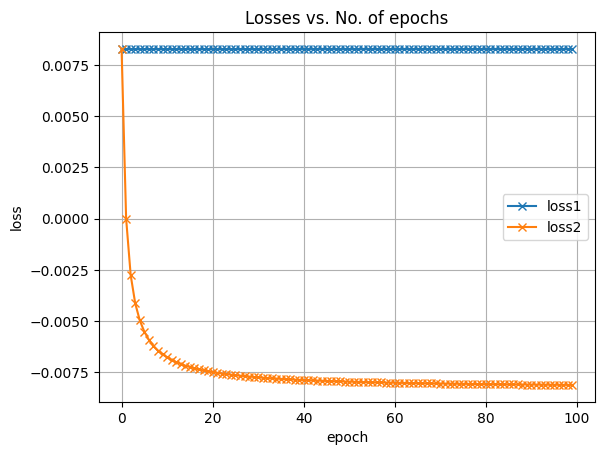

In [22]:
utils.plot_history(drying_history)

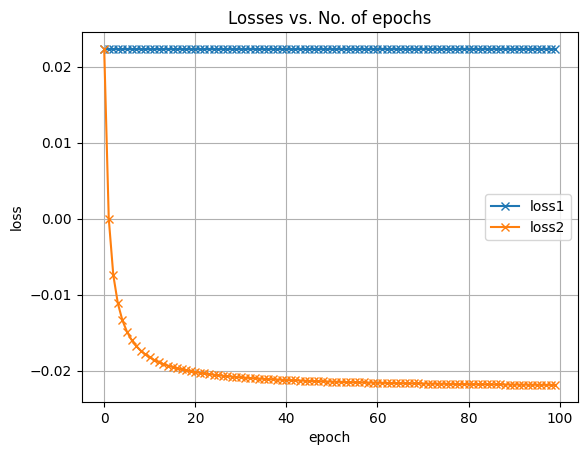

In [23]:
utils.plot_history(cleaning_history)

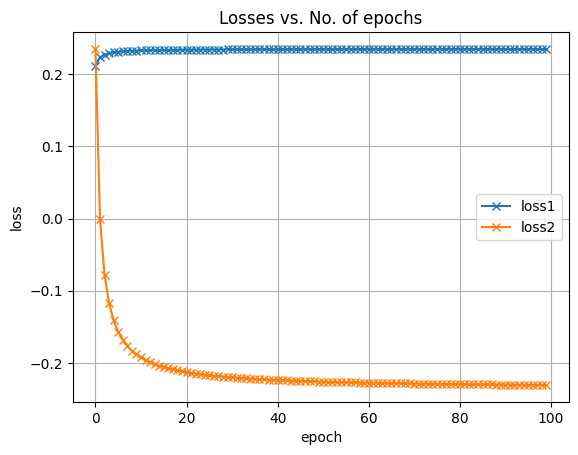

In [24]:
utils.plot_history(quenching_history)

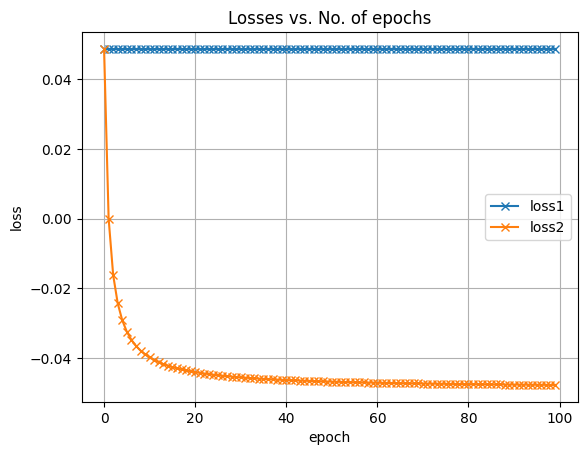

In [25]:
utils.plot_history(salt_history)

In [47]:
model_list = [drying_model, cleaning_model, quenching_model, salt_model]
model_name_list = ['건조', '세정', '소입', '솔트']

for name, model in zip(model_name_list, model_list):
    torch.save({
                'encoder': model.encoder.state_dict(),
                'decoder1': model.decoder1.state_dict(),
                'decoder2': model.decoder2.state_dict()
                }, "./epoch_"+N_EPOCHS+"_model/"+name+"/model.pth")

#### Testing

In [27]:
model_list = [drying_model, cleaning_model, quenching_model, salt_model]

In [18]:
model_list = [drying_model, cleaning_model, quenching_model, salt_model]
model_name_list = ['건조', '세정', '소입', '솔트']

for idx, model_name in enumerate(model_name_list):
    checkpoint = torch.load("./epoch_100_model/"+model_name+"/model.pth")
    model_list[idx].encoder.load_state_dict(checkpoint['encoder'])
    model_list[idx].decoder1.load_state_dict(checkpoint['decoder1'])
    model_list[idx].decoder2.load_state_dict(checkpoint['decoder2'])
    

In [19]:
drying_result = USAD.testing(model_list[0], test_loader_list[0], 0.5, 0.5)
cleaning_result = USAD.testing(model_list[1], test_loader_list[1], 0.5, 0.5)
quenching_result = USAD.testing(model_list[2], test_loader_list[2], 0.5, 0.5)
salt_result = USAD.testing(model_list[3], test_loader_list[3], 0.5, 0.5)

result_list = [drying_result, cleaning_result, quenching_result, salt_result]

In [20]:
window_label_list = []

for label in label_list:
    window_label=[]
    for i in range(len(label)-window_size):
        window_label.append(list(np.int_(label[i:i+window_size])))
    window_label_list.append(window_label)

In [21]:
y_test_list = []

for window_label in window_label_list:
    y_test = [1.0 if (np.sum(window) > 0 ) else 0 for window in window_label]
    y_test_list.append(y_test)

In [22]:
y_pred_list = []

for result in result_list:
    y_pred=np.concatenate([torch.stack(result[:-1]).flatten().detach().cpu().numpy(),
                                result[-1].flatten().detach().cpu().numpy()])
    y_pred_list.append(y_pred)


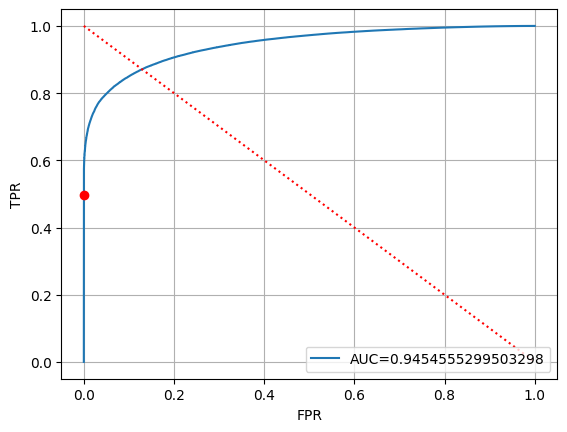

In [23]:
drying_threshold=utils.ROC(y_test_list[0],y_pred_list[0])

In [24]:
drying_threshold

array([0.02924678], dtype=float32)

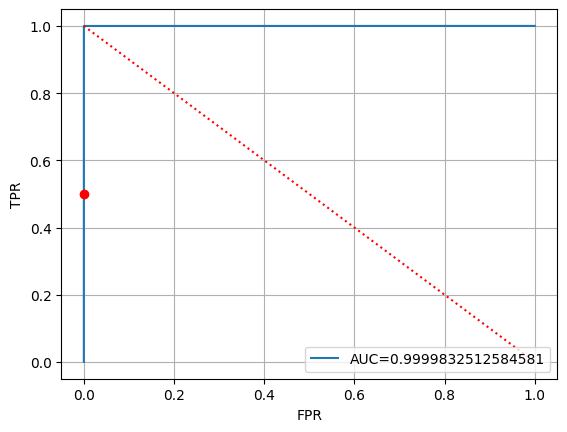

In [25]:
cleaning_threshold=utils.ROC(y_test_list[1],y_pred_list[1])

In [26]:
cleaning_threshold

array([0.24470037], dtype=float32)

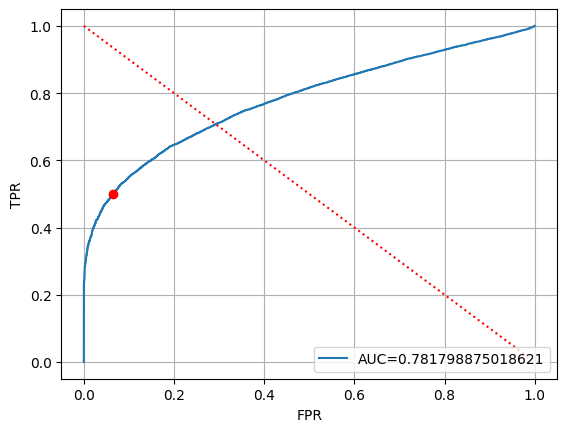

In [27]:
quenching_threshold=utils.ROC(y_test_list[2],y_pred_list[2])

In [28]:
quenching_threshold

array([0.2337188], dtype=float32)

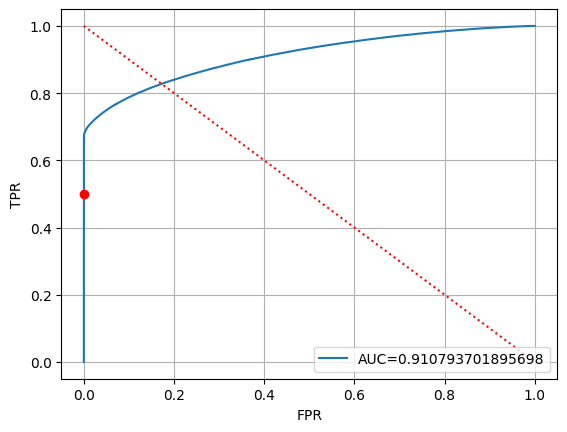

In [29]:
salt_threshold=utils.ROC(y_test_list[3],y_pred_list[3])

In [30]:
salt_threshold

array([0.9064767], dtype=float32)

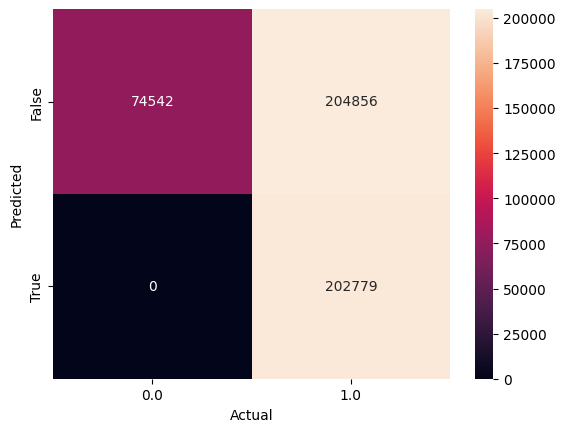

In [31]:
drying_cm = utils.confusion_matrix(y_test_list[0],y_pred_list[0]>drying_threshold)

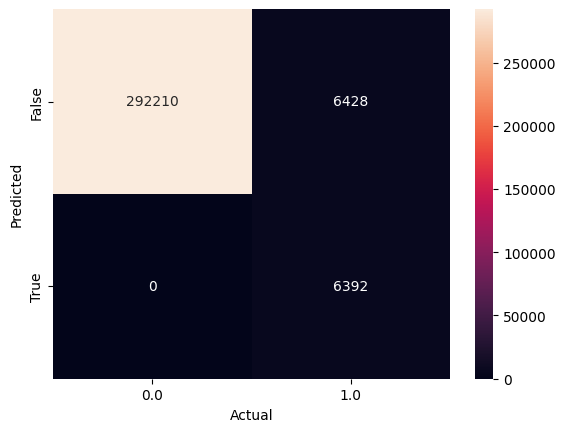

In [32]:
cleaning_cm = utils.confusion_matrix(y_test_list[1],y_pred_list[1]>cleaning_threshold)

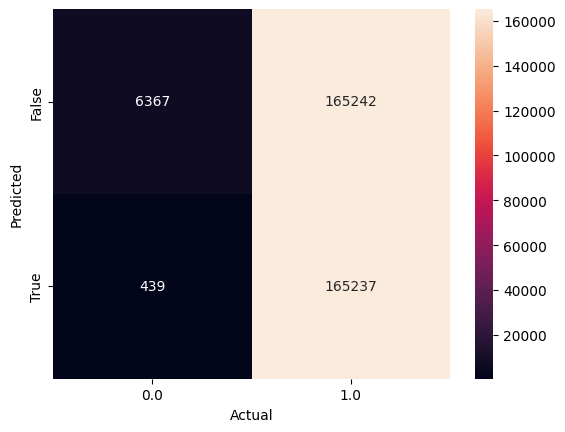

In [33]:
quenching_cm = utils.confusion_matrix(y_test_list[2],y_pred_list[2]>quenching_threshold)

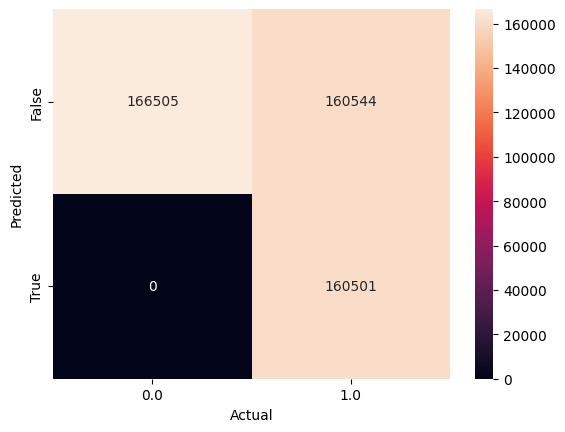

In [34]:
salt_cm = utils.confusion_matrix(y_test_list[3],y_pred_list[3]>salt_threshold)

In [38]:
th_list = [drying_threshold, cleaning_threshold, quenching_threshold, salt_threshold]

In [36]:
print("drying F1 Score : {}".format(f1_score(y_test_list[0],y_pred_list[0]>drying_threshold)))
print("clenaing F1 Score : {}".format(f1_score(y_test_list[1],y_pred_list[1]>cleaning_threshold)))
print("quenching F1 Score : {}".format(f1_score(y_test_list[2],y_pred_list[2]>quenching_threshold)))
print("salt F1 Score : {}".format(f1_score(y_test_list[3],y_pred_list[3]>salt_threshold)))

drying F1 Score : 0.6643982608524707
clenaing F1 Score : 0.6654174474286904
quenching F1 Score : 0.6660700789067933
salt F1 Score : 0.6666071361822131


In [ ]:
#데이터를 다루기 위한 라이브러리
import pandas as pd
import numpy as np

#진행도 출력
from tqdm import tqdm

#경고 메시지 미노출(결과 도출에 큰 차이 없음)
import warnings
warnings.filterwarnings(action='ignore')

#설비 데이터 경로
file_path='datas/data.csv'
file_q = 'datas/quality.xlsx'

#설비 데이터 로드
df = pd.read_csv(file_path, encoding='cp949')

In [ ]:
#그래프 관련 라이브러리 improt
import seaborn as sns
import matplotlib as mpl
import matplotlib.pylab as plt
from matplotlib import rc
import matplotlib.font_manager as fm

#그래프를 크게 보기 위한 설정
sns.set(rc={"figure.figsize": (15,8)})

#그래프에서 한글을 볼 수 있도록 한글 폰트 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf'

font = fm.FontProperties(fname=font_path).get_name()

rc('font', family=font)

#음수 부호 미노출 오류 제거
mpl.rcParams['axes.unicode_minus'] =False

In [ ]:
#data load확인
df.head()

,TAG_MIN,배정번호,건조 1존 OP,건조 2존 OP,건조로 온도 1 Zone,건조로 온도 2 Zone,세정기,소입1존 OP,소입2존 OP,소입3존 OP,...,소입로 CP 값,소입로 CP 모니터 값,소입로 온도 1 Zone,소입로 온도 2 Zone,소입로 온도 3 Zone,소입로 온도 4 Zone,솔트 컨베이어 온도 1 Zone,솔트 컨베이어 온도 2 Zone,솔트조 온도 1 Zone,솔트조 온도 2 Zone
0,2022-01-03 11:22:07,102410,75.6648,30.0155,NaN,NaN,68.4386,72.84030,59.7862,51.71690,...,0.450421,NaN,NaN,859.854,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-01-03 11:22:08,102410,75.6706,32.2732,NaN,NaN,68.4386,78.44150,61.6286,50.44530,...,0.450356,1.146260e-10,860.338,859.780,860.044,859.786,294.658,272.538,328.734,328.865
2,2022-01-03 11:22:09,102410,75.6776,32.1592,98.8533,99.14600,68.4386,78.10990,61.5414,52.01960,...,0.450341,1.145200e-10,860.338,859.780,859.981,859.724,294.658,272.538,328.734,328.805
3,2022-01-03 11:22:11,102410,75.8656,30.8312,98.7918,99.17675,68.4999,77.50725,60.6663,52.69425,...,0.450201,1.144670e-10,860.338,859.842,859.950,859.599,294.719,272.538,328.674,328.865
4,2022-01-03 11:22:12,102410,73.6468,29.5274,98.7918,99.20750,68.4386,76.02620,61.1634,51.69150,...,0.450235,1.145360e-10,860.351,859.791,859.991,859.731,294.721,272.599,328.740,328.808


In [ ]:
#데이터 형태 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2939722 entries, 0 to 2939721
Data columns (total 21 columns):
 #   Column             Dtype  
---  ------             -----  
 0   TAG_MIN            object 
 1   배정번호               int64  
 2   건조 1존 OP           float64
 3   건조 2존 OP           float64
 4   건조로 온도 1 Zone      float64
 5   건조로 온도 2 Zone      float64
 6   세정기                float64
 7   소입1존 OP            float64
 8   소입2존 OP            float64
 9   소입3존 OP            float64
 10  소입4존 OP            float64
 11  소입로 CP 값           float64
 12  소입로 CP 모니터 값       float64
 13  소입로 온도 1 Zone      float64
 14  소입로 온도 2 Zone      float64
 15  소입로 온도 3 Zone      float64
 16  소입로 온도 4 Zone      float64
 17  솔트 컨베이어 온도 1 Zone  float64
 18  솔트 컨베이어 온도 2 Zone  float64
 19  솔트조 온도 1 Zone      float64
 20  솔트조 온도 2 Zone      float64
dtypes: float64(19), int64(1), object(1)
memory usage: 471.0+ MB


In [ ]:
#object -> datetime으로 변경
df['TAG_MIN'] =pd.to_datetime(df.TAG_MIN, format='%Y-%m-%d')

In [ ]:
#data 기술통계 확인
df.describe()

,배정번호,건조 1존 OP,건조 2존 OP,건조로 온도 1 Zone,건조로 온도 2 Zone,세정기,소입1존 OP,소입2존 OP,소입3존 OP,소입4존 OP,소입로 CP 값,소입로 CP 모니터 값,소입로 온도 1 Zone,소입로 온도 2 Zone,소입로 온도 3 Zone,소입로 온도 4 Zone,솔트 컨베이어 온도 1 Zone,솔트 컨베이어 온도 2 Zone,솔트조 온도 1 Zone,솔트조 온도 2 Zone
count,2.939722e+06,2.939721e+06,2.939721e+06,2.939606e+06,2.939574e+06,2.939631e+06,2.935434e+06,2.939722e+06,2.939720e+06,2.939719e+06,2.939721e+06,2.939575e+06,2.939592e+06,2.939594e+06,2.939565e+06,2.939552e+06,2.939616e+06,2.939580e+06,2.939513e+06,2.939519e+06
mean,1.284422e+05,6.989404e+01,2.044708e+01,1.000061e+02,1.000198e+02,6.771864e+01,7.564373e+01,5.486239e+01,5.386029e+01,7.108925e+01,4.488618e-01,1.145580e-10,8.592077e+02,8.600021e+02,8.600029e+02,8.600062e+02,2.839963e+02,2.799293e+02,3.318062e+02,3.321773e+02
std,1.263704e+04,4.014802e+00,5.217123e+00,4.360371e-01,3.623526e-01,1.630768e+00,2.516083e+01,4.429079e+00,2.664304e+00,2.556959e+00,1.886477e-02,6.012797e-13,3.647667e+00,5.578480e-01,3.518205e-01,4.551778e-01,9.512770e+00,6.611579e+00,7.827379e-01,8.732977e-01
min,1.024100e+05,4.725320e+01,1.188830e-04,9.734210e+01,9.787060e+01,6.062440e+01,8.500550e-04,8.620010e+00,4.370450e-02,6.244200e-03,5.096370e-03,1.116620e-10,8.402980e+02,8.559290e+02,8.582800e+02,8.579920e+02,2.662300e+02,2.664260e+02,3.281610e+02,3.280730e+02
25%,1.194480e+05,6.842880e+01,1.891760e+01,9.981440e+01,9.989010e+01,6.656940e+01,6.496270e+01,5.332590e+01,5.238910e+01,6.967810e+01,4.484415e-01,1.142615e-10,8.579490e+02,8.597760e+02,8.598290e+02,8.598430e+02,2.747540e+02,2.735020e+02,3.318670e+02,3.321780e+02
50%,1.298890e+05,7.051660e+01,2.129310e+01,1.000020e+02,1.000190e+02,6.769720e+01,8.221040e+01,5.566540e+01,5.388620e+01,7.104540e+01,4.500620e-01,1.145550e-10,8.595750e+02,8.600220e+02,8.600020e+02,8.600000e+02,2.845860e+02,2.800200e+02,3.320170e+02,3.324230e+02
75%,1.391160e+05,7.237810e+01,2.338840e+01,1.001910e+02,1.001610e+02,6.897990e+01,9.536660e+01,5.757330e+01,5.541450e+01,7.247710e+01,4.517070e-01,1.148440e-10,8.602580e+02,8.602490e+02,8.601720e+02,8.601580e+02,2.933430e+02,2.863340e+02,3.321410e+02,3.326260e+02
max,1.480690e+05,8.729950e+01,4.753950e+01,1.024690e+02,1.018430e+02,7.149010e+01,1.000000e+02,7.727090e+01,6.601500e+01,8.739070e+01,9.091110e-01,1.329290e-10,8.772280e+02,8.660340e+02,8.701190e+02,8.821480e+02,2.985300e+02,2.916960e+02,3.327170e+02,3.331790e+02


In [ ]:
#이상치 개수에 넣지 않을 변수 제거
df.drop(['배정번호'], axis=1, inplace=True)

In [ ]:
#결측치 확인
df.isnull().sum()

TAG_MIN                 0
건조 1존 OP                1
건조 2존 OP                1
건조로 온도 1 Zone         116
건조로 온도 2 Zone         148
세정기                    91
소입1존 OP              4288
소입2존 OP                 0
소입3존 OP                 2
소입4존 OP                 3
소입로 CP 값                1
소입로 CP 모니터 값          147
소입로 온도 1 Zone         130
소입로 온도 2 Zone         128
소입로 온도 3 Zone         157
소입로 온도 4 Zone         170
솔트 컨베이어 온도 1 Zone     106
솔트 컨베이어 온도 2 Zone     142
솔트조 온도 1 Zone         209
솔트조 온도 2 Zone         203
dtype: int64

In [ ]:
print(len(df))

2939722


In [ ]:
#전체 데이터에 비해 결측치가 매우 적기 때문에 평균값으로 결측치 대체
df=df.fillna(df.mean())

In [ ]:
#결측치가 대체 되었는지 확인
df.isnull().sum()

TAG_MIN              0
건조 1존 OP             0
건조 2존 OP             0
건조로 온도 1 Zone        0
건조로 온도 2 Zone        0
세정기                  0
소입1존 OP              0
소입2존 OP              0
소입3존 OP              0
소입4존 OP              0
소입로 CP 값             0
소입로 CP 모니터 값         0
소입로 온도 1 Zone        0
소입로 온도 2 Zone        0
소입로 온도 3 Zone        0
소입로 온도 4 Zone        0
솔트 컨베이어 온도 1 Zone    0
솔트 컨베이어 온도 2 Zone    0
솔트조 온도 1 Zone        0
솔트조 온도 2 Zone        0
dtype: int64

In [ ]:
#일단위로 사용하기 위해서 Y-m-d형태로 바꿔준다.
df['TAG_MIN'] = df['TAG_MIN'].dt.strftime('%Y-%m-%d')

In [ ]:
#각 row의 이상치 개수를 보여주는 이상치 개수 파생변수 생성
df['이상치개수'] =0

In [ ]:
for col in df.columns[2:]:
    # IQR 계산
    thirdq, firstq = np.percentile(df[col], [75, 25])
    iqr = thirdq - firstq
    # 이상치 경계 설정
    outlierhigh, outlierlow = thirdq + 1.5 * iqr, firstq - 1.5 * iqr
    # 이상치 개수 카운트
    df['이상치개수'] += ((df[col] > outlierhigh) | (df[col] < outlierlow)).astype(int)


In [ ]:
df.head()

,TAG_MIN,건조 1존 OP,건조 2존 OP,건조로 온도 1 Zone,건조로 온도 2 Zone,세정기,소입1존 OP,소입2존 OP,소입3존 OP,소입4존 OP,...,소입로 CP 모니터 값,소입로 온도 1 Zone,소입로 온도 2 Zone,소입로 온도 3 Zone,소입로 온도 4 Zone,솔트 컨베이어 온도 1 Zone,솔트 컨베이어 온도 2 Zone,솔트조 온도 1 Zone,솔트조 온도 2 Zone,이상치개수
0,2022-01-03,75.6648,30.0155,100.006124,100.01977,68.4386,72.84030,59.7862,51.71690,71.8405,...,1.145580e-10,859.207729,859.854,860.002924,860.00623,283.996326,279.929326,331.806233,332.177348,0
1,2022-01-03,75.6706,32.2732,100.006124,100.01977,68.4386,78.44150,61.6286,50.44530,70.5198,...,1.146260e-10,860.338000,859.780,860.044000,859.78600,294.658000,272.538000,328.734000,328.865000,3
2,2022-01-03,75.6776,32.1592,98.853300,99.14600,68.4386,78.10990,61.5414,52.01960,72.0384,...,1.145200e-10,860.338000,859.780,859.981000,859.72400,294.658000,272.538000,328.734000,328.805000,5
3,2022-01-03,75.8656,30.8312,98.791800,99.17675,68.4999,77.50725,60.6663,52.69425,73.4815,...,1.144670e-10,860.338000,859.842,859.950000,859.59900,294.719000,272.538000,328.674000,328.865000,5
4,2022-01-03,73.6468,29.5274,98.791800,99.20750,68.4386,76.02620,61.1634,51.69150,71.6093,...,1.145360e-10,860.351000,859.791,859.991000,859.73100,294.721000,272.599000,328.740000,328.808000,4


In [ ]:
#이상치개수 분포
df['이상치개수'].value_counts()

0     1537791
1      536884
2      386600
3      261511
4      110706
5       58099
7       28107
8       12907
9        4539
10       1305
11        712
12        398
13        163
Name: 이상치개수, dtype: int64

In [ ]:
#시계열 분석을 위해 날짜와 이상치 개수만 가져온다.
data = df[['TAG_MIN', '이상치개수']]

In [ ]:
#새 데이터프레임 확인
data.head()

,TAG_MIN,이상치개수
0,2022-01-03,0
1,2022-01-03,3
2,2022-01-03,5
3,2022-01-03,5
4,2022-01-03,4


In [ ]:
#일별 시계열 분석을 위해 일별 이상치개수의 평균값을 보여주는 데이터프레임을 만든다.
data=data.groupby('TAG_MIN').mean()

In [ ]:
#컬럼의 의미가 바뀌었기 때문에 이름을 바꾸어준다.
data.rename(columns = {'이상치개수':'이상치평균'}, inplace=True)

In [ ]:
data.head()

,이상치평균
TAG_MIN,
2022-01-03,2.829241
2022-01-04,3.078708
2022-01-05,3.511110
2022-01-06,3.933588
2022-01-07,3.292176


In [ ]:
#index를 날짜로 바꿔준다.
data.index = pd.to_datetime(data.index)

In [ ]:
#데이터 프레임의 빈도확인
print(data.index.inferred_freq)

None


In [ ]:
#데이터 프레임의 빈도를 일별로 바꿔준다.
##바꿔주기 위해 사이의 비어있는 날짜들을 채워준다.
data = data.asfreq(freq='D')

In [ ]:
data.head()

,이상치평균
TAG_MIN,
2022-01-03,2.829241
2022-01-04,3.078708
2022-01-05,3.511110
2022-01-06,3.933588
2022-01-07,3.292176


In [ ]:
#새로 만든 날짜는 값이 없으므로 대체해주어야한다.
data.isnull().sum()

이상치평균    81
dtype: int64

In [ ]:
#결측치의 앞뒤값의 평균으로 보간한다.
data = data.fillna(data.interpolate())

In [ ]:
data.isnull().sum()

이상치평균    0
dtype: int64

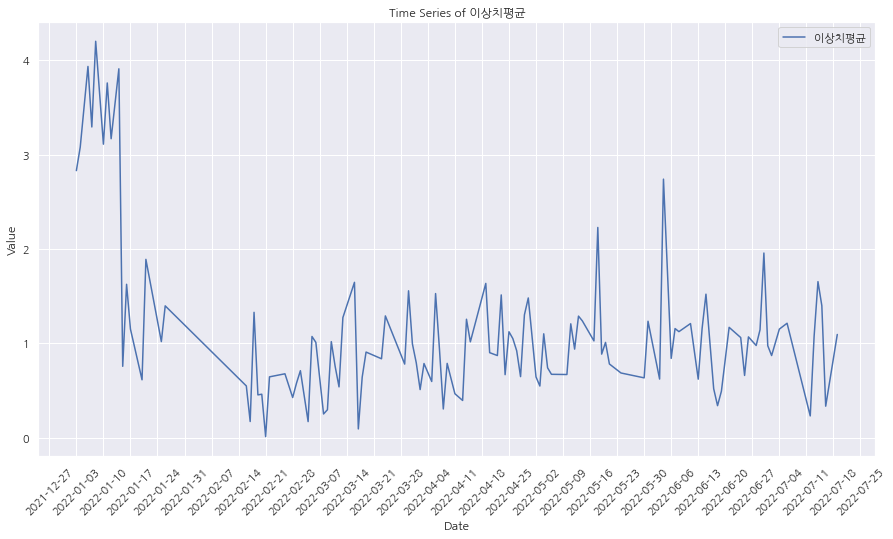

In [ ]:
#시계열 그래프 그리기 (주 단위로 표시)
plt.plot(data.index, data['이상치평균'], label='이상치평균')
plt.title('Time Series of 이상치평균')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.xticks(rotation=45)
ax=plt.gca()
ax.xaxis.set_major_locator(mpl.dates.WeekdayLocator(byweekday=mpl.dates.MO, interval=1))
plt.show()

In [ ]:
#품질 데이터 로드
df_q = pd.read_excel(file_q)

In [ ]:
#데이터 로드 확인
df_q

,배정번호,작업일,공정명,설비명,양품수량,불량수량,총수량
0,102410,2022-01-03,열처리,열처리 염욕_1,15160,3,15163
1,102585,2022-01-03,열처리,열처리 염욕_1,29892,10,29902
2,102930,2022-01-04,열처리,열처리 염욕_1,59616,30,59646
3,103142,2022-01-05,열처리,열처리 염욕_1,74730,13,74743
4,103675,2022-01-06,열처리,열처리 염욕_1,14979,2,14981
...,...,...,...,...,...,...,...
131,147292,2022-07-14,열처리,열처리 염욕_1,43765,12,43777
132,147546,2022-07-15,열처리,열처리 염욕_1,59957,16,59973
133,147982,2022-07-18,열처리,열처리 염욕_1,40981,12,40993
134,147996,2022-07-18,열처리,열처리 염욕_1,30239,9,30248


In [ ]:
#불량률 = 불량수량/총수량*100
df_q['불량률']=round(df_q['불량수량']/df_q['총수량']*100,3)
df_q

,배정번호,작업일,공정명,설비명,양품수량,불량수량,총수량,불량률
0,102410,2022-01-03,열처리,열처리 염욕_1,15160,3,15163,0.020
1,102585,2022-01-03,열처리,열처리 염욕_1,29892,10,29902,0.033
2,102930,2022-01-04,열처리,열처리 염욕_1,59616,30,59646,0.050
3,103142,2022-01-05,열처리,열처리 염욕_1,74730,13,74743,0.017
4,103675,2022-01-06,열처리,열처리 염욕_1,14979,2,14981,0.013
...,...,...,...,...,...,...,...,...
131,147292,2022-07-14,열처리,열처리 염욕_1,43765,12,43777,0.027
132,147546,2022-07-15,열처리,열처리 염욕_1,59957,16,59973,0.027
133,147982,2022-07-18,열처리,열처리 염욕_1,40981,12,40993,0.029
134,147996,2022-07-18,열처리,열처리 염욕_1,30239,9,30248,0.030


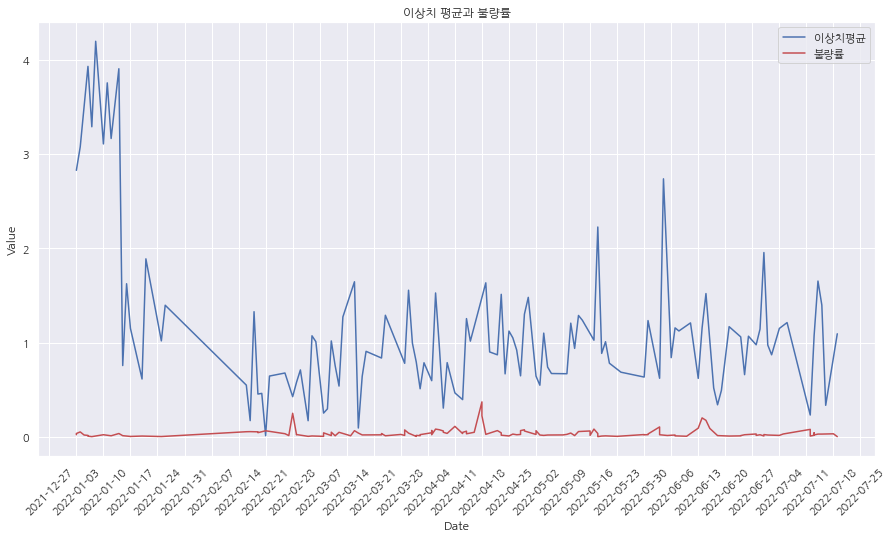

In [ ]:
#이상치평균과 불량률 시계열 그래프 그리기
plt.plot(data.index, data['이상치평균'], label='이상치평균')
plt.plot(df_q['작업일'], df_q['불량률'], label='불량률', c='r')
plt.title('이상치 평균과 불량률')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.xticks(rotation=45)
ax=plt.gca()
ax.xaxis.set_major_locator(mpl.dates.WeekdayLocator(byweekday=mpl.dates.MO, interval=1))
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller

#시계열 그래프의 정상성 체크

result = adfuller(data['이상치평균'])
## 결과 출력
print('Variable: 이상치평균')
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])
print('Is Stationary:', result[1] < 0.05)

Variable: 이상치평균
ADF Statistic: -4.301189048944156
p-value: 0.0004421109720391214
Critical Values: {'1%': -3.4645146202692527, '5%': -2.8765564361715534, '10%': -2.5747745328940375}
Is Stationary: True


In [ ]:
import pmdarima as pm
from pmdarima.arima import ndiffs
# ARIMA(p, d, q)에서의 차분(d차수)을 얼마나 해야하는 지를 나타낸다.
n_diffs = ndiffs(data, alpha=0.05, test='adf', max_d=6)
print(f"추정된 차수 d = {n_diffs}") # 결과

추정된 차수 d = 0


In [ ]:
#최적의 p, q 값
## AIC가 낮을 수록 좋은 모델이다.
model = pm.auto_arima(
            y=data, 
            d=0, 
            start_p=0, max_p=2, 
            start_q=0, max_q=2, 
            m=1, seasonal=False, # 계절성이 없음!
            stepwise=True,
            trace=True
)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=670.544, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=285.300, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=504.861, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=270.036, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=254.455, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=255.570, Time=0.04 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=255.611, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=253.911, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=436.393, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=252.574, Time=0.14 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=314.876, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=252.982, Time=0.13 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=253.862, Time=0.18 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=342.965, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=253.1

In [ ]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  198
Model:               SARIMAX(1, 0, 2)   Log Likelihood                -121.287
Date:                Thu, 02 Nov 2023   AIC                            252.574
Time:                        16:27:23   BIC                            269.015
Sample:                    01-03-2022   HQIC                           259.229
                         - 07-19-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0440      0.031      1.429      0.153      -0.016       0.104
ar.L1          0.9659      0.018     54.877      0.000       0.931       1.000
ma.L1         -0.4295      0.090     -4.768      0.0

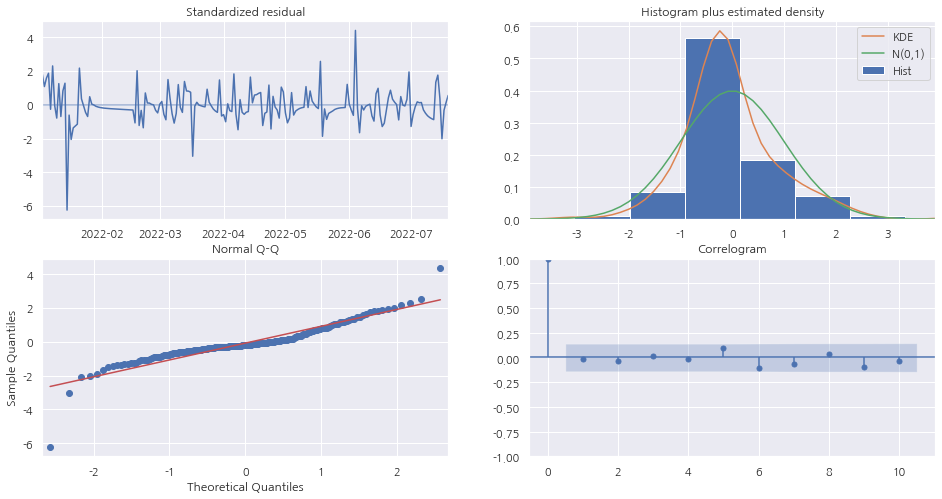

In [ ]:
model.plot_diagnostics(figsize=(16,8))
plt.show()

In [ ]:
#예측을 위해 기존의 데이터를 train과 test를 9:1비율로 나누어준다.
train_data, test_data = data[:int(len(data)*0.9)], data[int(len(data)*0.9):]

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

model_fit = pm.auto_arima(
    	    y=train_data, 
 	        d=n_diffs , 
            start_p=0, max_p=2, 
            start_q=0, max_q=2, 
            m=1, seasonal=False, # 계절성이 없음!
            stepwise=True,
            trace=True
)
print(model_fit.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=610.129, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=260.030, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=460.999, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=242.956, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=231.413, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=230.522, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=231.167, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=400.083, Time=0.03 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=231.948, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=228.421, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=319.349, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=246.345, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=229.895, Time=0.17 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=229.698, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=407.9

In [ ]:
# forecast 함수
def forecast_n_step(model, n = 1):
    fc, conf_int = model.predict(n_periods=n, return_conf_int=True)
    # print("fc", fc,"conf_int", conf_int)
    return (
        fc.tolist()[0:n], np.asarray(conf_int).tolist()[0:n]
   )

def forecast(len, model, index, data=None):
    y_pred = []
    pred_upper = []
    pred_lower = []

    if data is not None:
         for idx, row in data.iterrows():
            new_ob=0
            for value in row:
                new_ob=value   
            fc, conf = forecast_n_step(model)
            y_pred.append(fc[0])
            pred_upper.append(conf[0][1])
            pred_lower.append(conf[0][0])
            model.update(new_ob)
    else:
        for i in range(len):
            fc, conf = forecast_n_step(model)
            y_pred.append(fc[0])
            pred_upper.append(conf[0][1])
            pred_lower.append(conf[0][0])
            model.update(fc[0])
    return pd.Series(y_pred, index=index), pred_upper, pred_lower

In [ ]:
# Forecast 
fc, upper, lower = forecast(len(test_data), model_fit, test_data.index, data = test_data)

# pandas series 생성
# fc # 예측결과
lower_series = pd.Series(lower, index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(upper, index=test_data.index)  # 예측결과의 상한 바운드

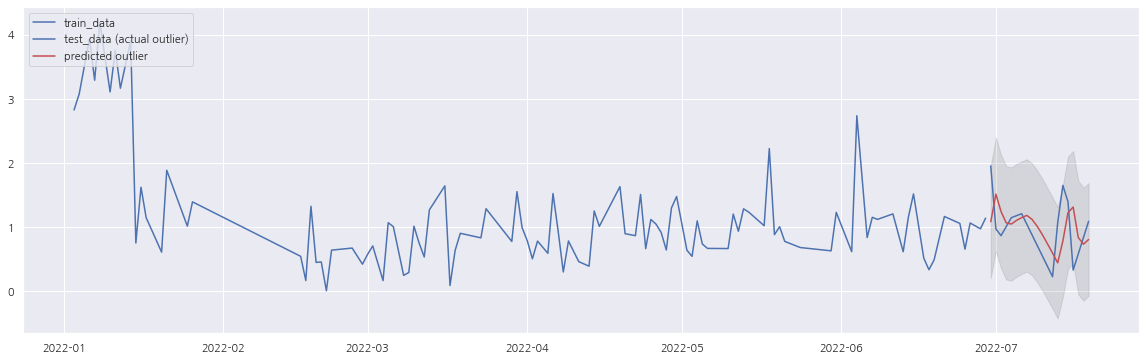

In [ ]:
# Plot
plt.figure(figsize=(20,6))
plt.plot(train_data, label='train_data')
plt.plot(test_data, c='b', label='test_data (actual outlier)')
plt.plot(fc, c='r',label='predicted outlier')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend(loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
#지표
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)
mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)
rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

MSE:  2.096552957345085
MAE:  1.0246961859443418
RMSE:  1.4479478434477828


In [ ]:
#데이터가 없는 날짜(미래) 예측
date_index = pd.date_range(start = "2022-07-19", end = "2022-08-10", freq='D')
fc2, upper2, lower2 = forecast(len(date_index), model_fit, date_index)
print('동향') 
print(fc2.tail())

# fc2, conf = forecast_n_step(model_fit, len(date_list))
lower_series2 = pd.Series(lower2, index=date_index)  # 예측결과의 하한 바운드
upper_series2 = pd.Series(upper2, index=date_index)  # 예측결과의 상한 바운드

동향
2022-08-06    1.123108
2022-08-07    1.128781
2022-08-08    1.133638
2022-08-09    1.138798
2022-08-10    1.143180
Freq: D, dtype: float64


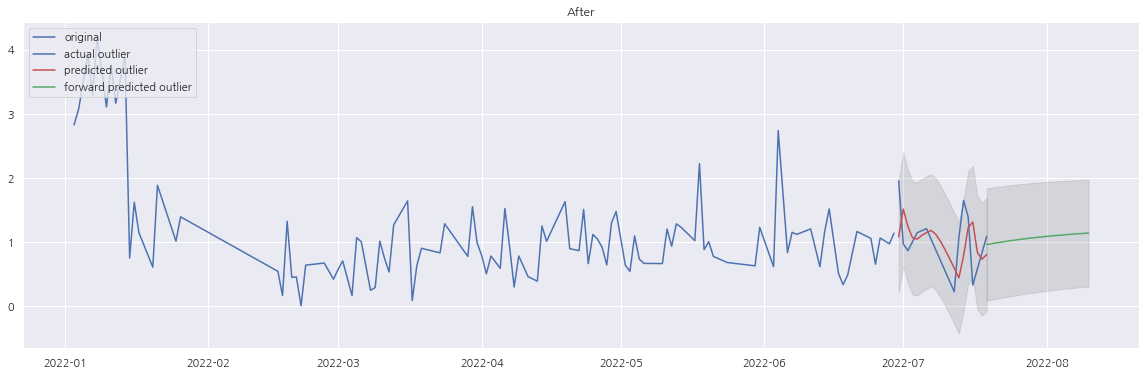

In [ ]:
# plot
plt.figure(figsize=(20,6))
plt.plot(train_data, label='original')
plt.plot(test_data, c='b', label='actual outlier')
plt.plot(fc, c='r',label='predicted outlier')
plt.plot(fc2, c='g',label='forward predicted outlier')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.fill_between(lower_series2.index, lower_series2, upper_series2, color='k', alpha=.10)
plt.title('After')
plt.legend(loc='upper left')
plt.show()